In [ ]:
# !pip install -r requirements.txt

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, regularizers, optimizers

from tqdm import tqdm

import requests
import os
import tarfile
import urllib.request
import librosa
from glob import glob

In [2]:
# Download/Exract Dataset
DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

url = "https://www.openslr.org/resources/17/musan.tar.gz"
filename = os.path.join(DATA_DIR, "musan.tar.gz")

def download_with_progress(url, filename):
    """Download a file from a URL."""

    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024 # 1 Kibibyte

    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(filename, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

# Download
if not os.path.exists(filename):
    print("Downloading MUSAN dataset... (aprox. 15-20mins)")
    download_with_progress(url, filename)
    print("Download complete.")

# Extract
print("Extracting...")
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall(path=DATA_DIR)
print("Extraction complete.")

100%|██████████| 11.1G/11.1G [09:27<00:00, 19.5MiB/s]
/tmp/ipython-input-1068004828.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_DIR)


Download complete.
Extracting...
Extraction complete.


In [3]:
# HD Configuration
DATA_DIR = './data'
SAMPLE_RATE = 16000
DURATION = 3
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048 # Increased fft for better detail
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Help function
def extract_log_melspectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(y) == 0 or np.max(np.abs(y)) == 0:
            return np.zeros((N_MELS, int(np.ceil(SAMPLES_PER_TRACK / HOP_LENGTH)), 1))

        y = y / np.max(np.abs(y))

        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        # HD Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel = np.maximum(mel, 1e-10)
        log_mel = librosa.power_to_db(mel, ref=np.max)

        # Normalize
        log_mel = (log_mel + 80) / 80.0
        return np.clip(log_mel, 0, 1)[..., np.newaxis]

    except Exception as e:
        print(f"Error: {e}")
        return np.zeros((N_MELS, int(np.ceil(SAMPLES_PER_TRACK / HOP_LENGTH)), 1))

# Data and balancing
all_music = glob(f'{DATA_DIR}/musan/music/**/*.wav', recursive=True)[:500]
all_speech = glob(f'{DATA_DIR}/musan/speech/**/*.wav', recursive=True)[:500]
all_noise = glob(f'{DATA_DIR}/musan/noise/**/*.wav', recursive=True)[:500]

files = all_music + all_speech + all_noise
labels = (['music'] * len(all_music)) + (['speech'] * len(all_speech)) + (['noise'] * len(all_noise))

le = LabelEncoder()
y_encoded = le.fit_transform(labels)
X_train, X_val, y_train, y_val = train_test_split(files, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Generator with Safe Augmentation
class AudioGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=32, augment=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = []

        for f in batch_x:
            try:
                y, sr = librosa.load(f, sr=SAMPLE_RATE, duration=DURATION)

                # Raw Audio Augmentation
                if self.augment:
                    # Time Shift
                    if np.random.random() < 0.5:
                        shift = np.random.randint(len(y) * 0.2)
                        y = np.roll(y, shift)
                    # Gain
                    if np.random.random() < 0.5:
                        y = y * np.random.uniform(0.8, 1.2)

                # Preprocessing
                if len(y) < SAMPLES_PER_TRACK:
                    y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
                else:
                    y = y[:SAMPLES_PER_TRACK]

                mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
                mel = np.maximum(mel, 1e-10)
                log_mel = librosa.power_to_db(mel, ref=np.max)
                spec = np.clip((log_mel + 80) / 80.0, 0, 1)

                # Spectrogram Augmentation
                if self.augment:
                    # Frequency Masking
                    if np.random.random() < 0.5:
                        num_freqs = N_MELS
                        f_width = np.random.randint(1, int(num_freqs * 0.15)) # Mask up to 15%
                        f_start = np.random.randint(0, num_freqs - f_width)
                        spec[f_start:f_start+f_width, :] = 0

                    # Time Masking
                    if np.random.random() < 0.5:
                        num_times = spec.shape[1]
                        t_width = np.random.randint(1, int(num_times * 0.15)) # Mask up to 15%
                        t_start = np.random.randint(0, num_times - t_width)
                        spec[:, t_start:t_start+t_width] = 0

                X_batch.append(spec[..., np.newaxis])

            except:
                X_batch.append(np.zeros((N_MELS, int(np.ceil(SAMPLES_PER_TRACK / HOP_LENGTH)), 1)))

        return np.array(X_batch), np.array(batch_y)

# Re-init
train_gen = AudioGenerator(X_train, y_train, augment=True)
val_gen = AudioGenerator(X_val, y_val, augment=False)
print("Generator updated with SpecAugment.")

train_gen = AudioGenerator(X_train, y_train, augment=True)
val_gen = AudioGenerator(X_val, y_val, augment=False)
print(f"Generators Ready. Input Shape: ({N_MELS}, {int(np.ceil(SAMPLES_PER_TRACK / HOP_LENGTH))}, 1)")

Generator updated with SpecAugment.
Generators Ready. Input Shape: (128, 94, 1)


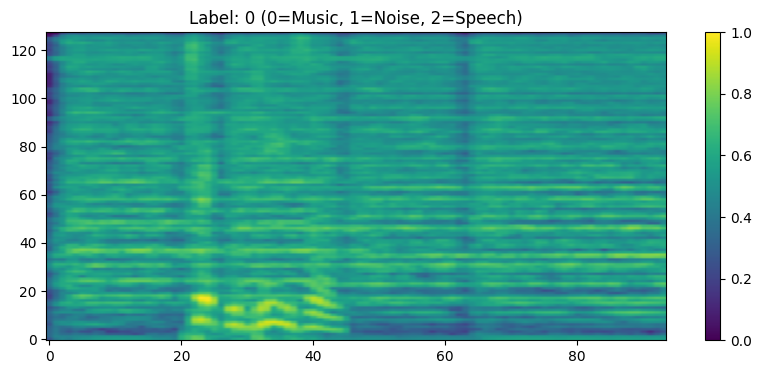

Data Stats - Min: 0.00, Max: 1.00, Mean: 0.39


In [4]:
# Get a batch
X_batch, y_batch = val_gen[0]

# Plot the first sample
plt.figure(figsize=(10, 4))
plt.imshow(X_batch[0].squeeze(), aspect='auto', origin='lower', cmap='viridis')
plt.title(f"Label: {y_batch[0]} (0=Music, 1=Noise, 2=Speech)")
plt.colorbar()
plt.show()

print(f"Data Stats - Min: {X_batch.min():.2f}, Max: {X_batch.max():.2f}, Mean: {X_batch.mean():.2f}")

Batch Shape: (32, 128, 94, 1)
Data Min: 0.0, Data Max: 1.0
Is the entire batch zeros? False


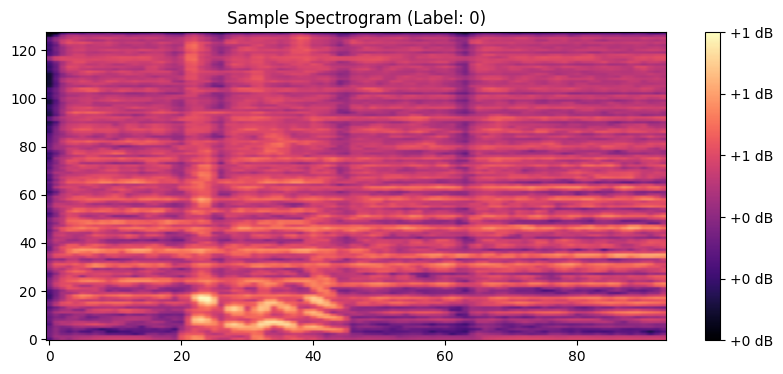

Data looks valid.


In [5]:
# visualize and check data debug

# Get one batch from the validation generator
X_batch, y_batch = val_gen[0]

print(f"Batch Shape: {X_batch.shape}")
print(f"Data Min: {X_batch.min()}, Data Max: {X_batch.max()}")
print(f"Is the entire batch zeros? {np.all(X_batch == 0)}")

# Plot the first spectrogram in the batch
plt.figure(figsize=(10, 4))
plt.imshow(X_batch[0].squeeze(), aspect='auto', origin='lower', cmap='magma')
plt.title(f"Sample Spectrogram (Label: {y_batch[0]})")
plt.colorbar(format='%+2.0f dB')
plt.show()

# Check if we have valid non-zero data
if X_batch.max() == 0:
    print("CRITICAL ERROR: Your data is all Zeros. Check your dataset path!")
else:
    print("Data looks valid.")

In [6]:


# Input: (128 Mels, Time, 1)
input_shape = (N_MELS, int(np.ceil(SAMPLES_PER_TRACK / HOP_LENGTH)), 1)

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 1 Wide
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 2 Capture Texture
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3 Complex Patterns
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aggregation
    layers.GlobalAveragePooling2D(),

    # Classifier
    layers.Dense(128, activation='relu'), # increased dense layer size
    layers.Dropout(0.2), # dropout low for learning
    layers.Dense(3, activation='softmax')
])

# standard adam
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,571 (428.01 KB)

 Trainable params: 109,571 (428.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.000001
)

# Train
print("Starting training with lower learning rate...")
history = model.fit(
    train_gen,
    epochs=25, # 25 because of the lower learning rate
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Starting training with lower learning rate...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - accuracy: 0.3472 - loss: 1.0991 - val_accuracy: 0.3462 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.4265 - loss: 1.0756 - val_accuracy: 0.3741 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.4050 - loss: 1.0821 - val_accuracy: 0.5035 - val_loss: 1.0071 - learning_rate: 0.0010
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.4403 - loss: 1.0337 - val_accuracy: 0.5105 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 391ms/step - accuracy: 0.4876 - loss: 0.9789 - val_accuracy: 0.4790 - val_loss: 1.0216 - learning_rate: 0.0010
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.5526 - loss: 0.9227 - val_accuracy: 0.6084 - val_loss: 0.8526 - learning_rate: 0.0010
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.6869 - loss: 0.

In [8]:
# Switch Generator to Clean Mode without Augmentation
# for the model tosee clear, unmasked signals now
train_gen_clean = AudioGenerator(X_train, y_train, augment=False)

# Lower Learning Rate significantly to
# prevent destroying the weights.
# Standard Adam is 1e-3. Here I use 1e-5 (100x slower).
optimizer_fine = optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer_fine,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-Tune
print("Starting Phase 2: Fine-Tuning on clean data...")
history_fine = model.fit(
    train_gen_clean,
    epochs=10,  # Short run
    validation_data=val_gen,
    callbacks=[early_stop] # Keep early stopping
)

Starting Phase 2: Fine-Tuning on clean data...
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - accuracy: 0.8928 - loss: 0.3110 - val_accuracy: 0.8776 - val_loss: 0.4140
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.8911 - loss: 0.3232 - val_accuracy: 0.8776 - val_loss: 0.4109
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.8988 - loss: 0.3067 - val_accuracy: 0.8811 - val_loss: 0.4091
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8994 - loss: 0.2993 - val_accuracy: 0.8811 - val_loss: 0.4075
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8935 - loss: 0.2950 - val_accuracy: 0.8846 - val_loss: 0.4061
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8957 - loss: 0.2933 - val_accuracy: 0.8846 - val_loss: 0.4053
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.8944 - loss: 0.2993 - val_accuracy: 0.8881 - val_loss: 0.4044
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/st

In [9]:
!mkdir -p /content/models
model.save("/content/models/audio_classifier.keras")
print("Keras model saved.")

Keras model saved.


In [13]:
# TFLite Conversion

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable SELECT_TF_OPS
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert
try:
    tflite_model = converter.convert()
    with open('/content/models/model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Success! TFLite model saved.")
except Exception as e:
    print(e)

Saved artifact at '/tmp/tmpks82t206'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 94, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136364523699280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523688336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523695440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523699088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523696016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523692176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523693520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523697936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364523683920: TensorSpec(shape=(), dtype=tf.resource, name=None)
Success! TFLite m

Class Mapping: ['music' 'noise' 'speech']

 Evaluating Keras Model (.h5)
Running inference on Keras model...


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



 Evaluating TFLite Model (.tflite)
Running inference on TFLite model (this is slower as it runs 1-by-1)...


100%|██████████| 286/286 [00:03<00:00, 86.33it/s]



Classification Report for Keras Model:
              precision    recall  f1-score   support

       music       0.95      0.87      0.91       100
       noise       0.83      0.92      0.87       100
      speech       0.93      0.90      0.91        86

    accuracy                           0.90       286
   macro avg       0.90      0.90      0.90       286
weighted avg       0.90      0.90      0.90       286



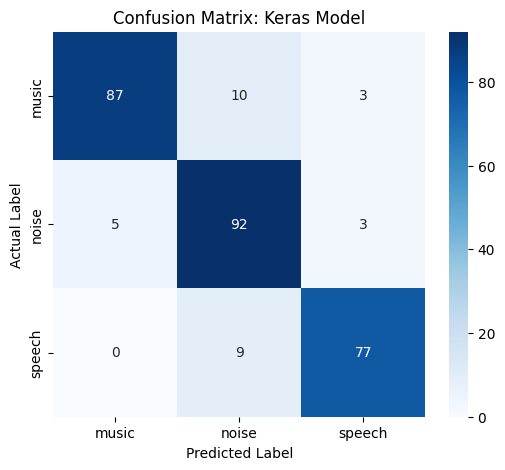


Classification Report for TFLite Model:
              precision    recall  f1-score   support

       music       0.95      0.87      0.91       100
       noise       0.83      0.92      0.87       100
      speech       0.93      0.90      0.91        86

    accuracy                           0.90       286
   macro avg       0.90      0.90      0.90       286
weighted avg       0.90      0.90      0.90       286



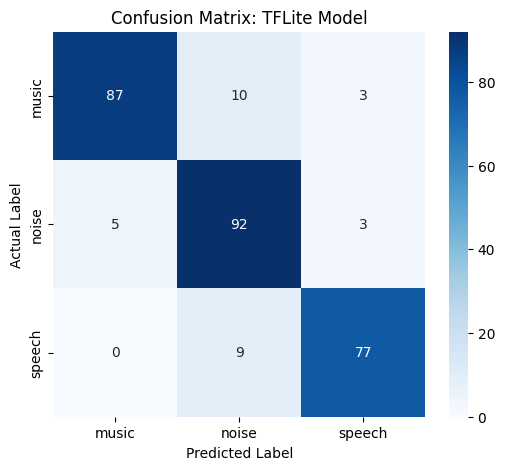

In [15]:
# Evaluation

# Define Labels Map
label_map = le.inverse_transform([0, 1, 2])
print(f"Class Mapping: {label_map}")


# EVALUATE KERAS MODEL (.h5)
print("\n Evaluating Keras Model (.h5)")
# Generate predictions for the whole validation set
# the generator handles loading audio files efficiently
y_pred_keras = []
y_true = []

# Iterate through validation generator
print("Running inference on Keras model...")
for i in tqdm(range(len(val_gen))):
    batch_x, batch_y = val_gen[i]
    preds = model.predict(batch_x, verbose=0)

    y_pred_keras.extend(np.argmax(preds, axis=1))
    y_true.extend(batch_y)

# EVALUATE TFLITE MODEL (.tflite)
print("\n Evaluating TFLite Model (.tflite)")

# Load TFLite Interpreter
interpreter = tf.lite.Interpreter(model_path="/content/models/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_pred_tflite = []

print("Running inference on TFLite model (this is slower as it runs 1-by-1)...")
# We manually load files here because TFLite usually processes single samples
for file_path in tqdm(X_val):
    # Process audio using the SAME function as training
    # Output shape is (64, 94, 1) but needs to be (1, 64, 94, 1) for TFLite
    input_data = extract_log_melspectrogram(file_path)
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

    # Run Inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    y_pred_tflite.append(np.argmax(output_data))

# VISUALIZATION
def plot_evaluation(y_true, y_pred, title):
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred, target_names=label_map))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map, yticklabels=label_map)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Show Results
# y_true matches y_pred_keras. For tflite, iterated X_val directly.
# need y_val (encoded labels) to match the order of X_val.
plot_evaluation(y_true, y_pred_keras, "Keras Model")
plot_evaluation(y_val, y_pred_tflite, "TFLite Model")

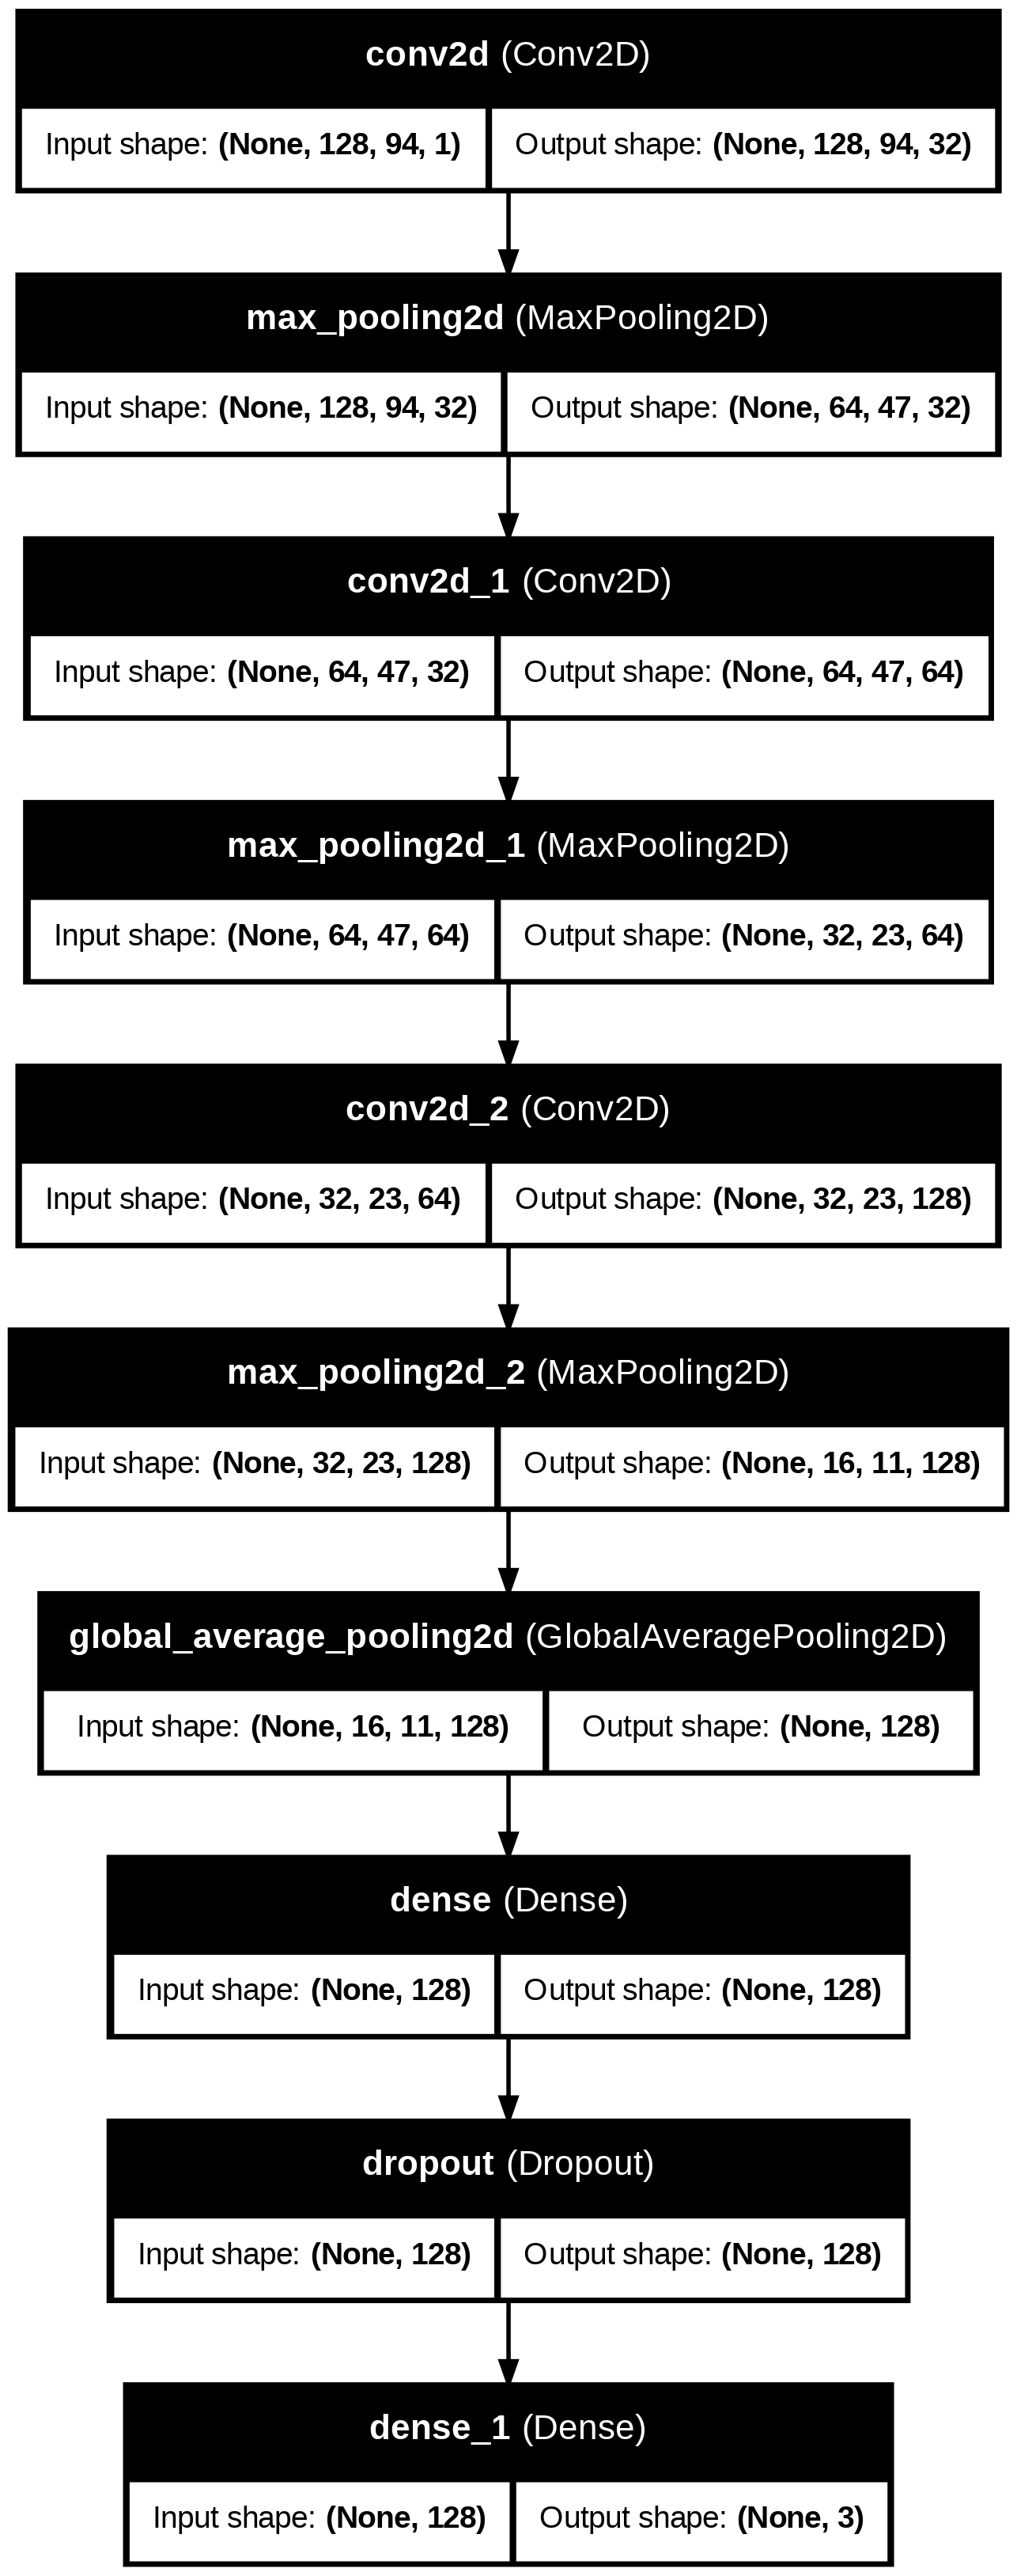

In [18]:
from keras.utils import plot_model
from keras.models import load_model

# Load model
model = load_model('/content/models/audio_classifier.keras')

# Generate visualization
plot_model(
    model,
    to_file='cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
# !pip install huggingface_hub

In [ ]:
# from huggingface_hub import login, upload_folder

# # (optional) Login with your Hugging Face credentials
# login()

In [ ]:
# from huggingface_hub import login, HfApi

# # Instantiate HfApi
# api_client = HfApi()

# # Push your dataset files using upload_large_folder
# api_client.upload_large_folder(
#     folder_path="/content/data/musan",
#     repo_id="stefbil/MLME_Dataset",
#     repo_type="dataset"
# )